# Cyclic peptides

In [1]:
import pandas as pd
df_all= pd.read_csv('data/CycPeptMPDB/all.csv')
df_train = pd.read_csv('data/CycPeptMPDB/train.csv')
df_test = pd.read_csv('data/CycPeptMPDB/test.csv')

In [2]:
pd.set_option('display.max_colwidth', None)

df_all.head()['helm']

0    PEPTIDE2{[Abu].[Sar].[meL].V.[meL].A.[dA].[meL].[meL].[meV].[Me_Bmt(E)]}$PEPTIDE2,PEPTIDE2,1:R1-11:R2$$$
1                                               PEPTIDE1{[dL].[dL].L.[dL].P.Y}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$
2                                            PEPTIDE1{[dL].[dL].[dL].[dL].P.Y}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$
3                                                     PEPTIDE1{L.L.L.[dL].P.Y}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$
4                                               PEPTIDE1{L.[dL].[dL].[dL].P.Y}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$
Name: helm, dtype: object

## Use XGBoost regressor

In [3]:
import io
import subprocess
import warnings
import numpy as np
import pandas as pd
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import AllChem, Descriptors, QED
import pickle
import gzip
from typing import List
import logging
from tqdm import tqdm

rdBase.DisableLog('rdApp.error')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def fingerprints_from_smiles(smiles: List, size=2048):
    """
        Create ECFP fingerprints of smiles, with validity check
    """
    fps = []
    valid_mask = []
    for i, smile in enumerate(smiles):
        mol = Chem.MolFromSmiles(smile)
        valid_mask.append(int(mol is not None))
        fp = fingerprints_from_mol(mol, size=size) if mol else np.zeros((1, size))
        fps.append(fp)

    fps = np.concatenate(fps, axis=0)
    return fps, valid_mask


def fingerprints_from_mol(molecule, radius=3, size=2048, hashed=False):
    """
        Create ECFP fingerprint of a molecule
    """
    if hashed:
        fp_bits = AllChem.GetHashedMorganFingerprint(molecule, radius, nBits=size)
    else:
        fp_bits = AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=size)
    fp_np = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp_bits, fp_np)
    return fp_np.reshape(1, -1)

In [4]:
X = fingerprints_from_smiles(df_all.smi)[0]
y = df_all.score.values

In [5]:
X.shape, y.shape

((7451, 2048), (7451,))

## Models

In [7]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# model = RandomForestRegressor(max_depth=5, random_state=0)

# create an xgboost regression model
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

## All to all evaluation

In [8]:
# plot the scatter plot of y and y_hat
import matplotlib.pyplot as plt

def plot_scatter_y(y, y_hat, x_label='y', y_label='y_hat', save_path=None):
    plt.scatter(y, y_hat, alpha=0.1)
    print(f'MAE: {np.mean(np.abs(y - y_hat))}, y mean: {np.mean(y)}, y_hat mean: {np.mean(y_hat)}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

MAE: 0.3738638264527178, y mean: -5.866279694000805, y_hat mean: -5.865070343017578


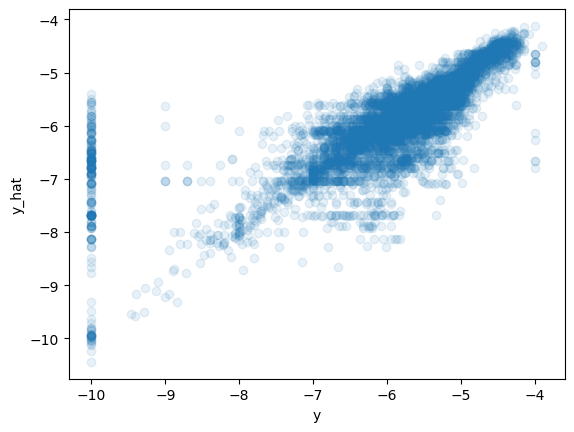

In [9]:
model.fit(X, y)
y_hat = model.predict(X)
plot_scatter_y(y, y_hat)

## Train test evaluation

In [10]:
# Split df_cycpdb into train, test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

MAE: 0.5095824167314269, y mean: -5.875653923541247, y_hat mean: -5.850254058837891


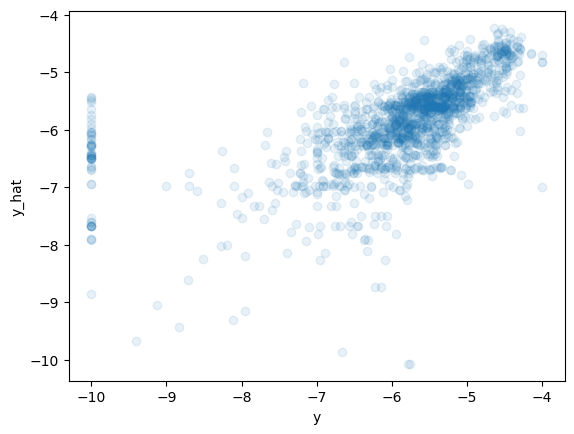

In [11]:
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
plot_scatter_y(y_test, y_hat)

In [12]:
model.save_model('data/CycPeptMPDB/xgbr_model.json')

MAE: 0.5095824167314269, y mean: -5.875653923541247, y_hat mean: -5.850254058837891


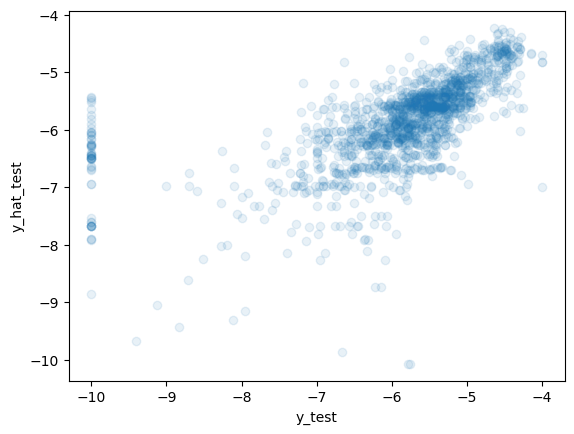

In [13]:
model = XGBRegressor()
model.load_model('data/CycPeptMPDB/xgbr_model.json')


y_hat = model.predict(X_test)
plot_scatter_y(y_test, y_hat, x_label='y_test', y_label='y_hat_test', save_path='data/CycPeptMPDB/xgbr_model.pdf')

## Evaluate model by N-fold

In [14]:
from numpy import absolute
from sklearn.model_selection import RepeatedKFold, cross_val_score


# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=None)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.515 (0.022)
